# Построение доверительного интервала для определения аномалий
Вы работаете аналитиком в компании, которая занимается арендой велосипедов.  
Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017.  
Вам предстоит изучить динамику числа аренд, наличие сезонности а также объяснить несколько аномалий на графике.

Задания:  
Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков.  
Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.  
Постройте график по числу поездок по дате и времени.  
Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.  
Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3.  
Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего.  
Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.  
Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.  
Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.

In [12]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv('london.csv', parse_dates=['timestamp'])
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


timestamp – дата и время (точность до часа)  
cnt – количество аренд велосипедов за этот час  
t1 – температура, в С  
t2 – температура "ощущается как", в С   
hum – влажность (%)  
wind_speed – скорость ветра, км/ч  
weather_code – погодные условия:  
1 – ясно (SKC)  
2 – преимущественно ясно / встречаются отдельные облака (SCT)  
3 – облачно / значительные облака (BKN)  
4 – пасмурно (OVC)  
7 – небольшой дождь Rain/ light Rain shower/ Light rain   
10 – дождь с грозой  
26 – снегопад   
94 – ледяной туман (да, такое бывает!, но в выборке нет)  
isholiday – является ли день праздником (1 – праздник, 0 – нет)  
isweekend –  является ли день выходным (1 – выходной, 0 – нет)  
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)  

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [15]:
data.nunique()

timestamp       17414
cnt              3781
t1                 73
t2                 82
hum               143
wind_speed        103
weather_code        7
is_holiday          2
is_weekend          2
season              4
dtype: int64

In [16]:
data.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [17]:
print('Пропущеных значений', data.isna().sum().sum())

Пропущеных значений 0


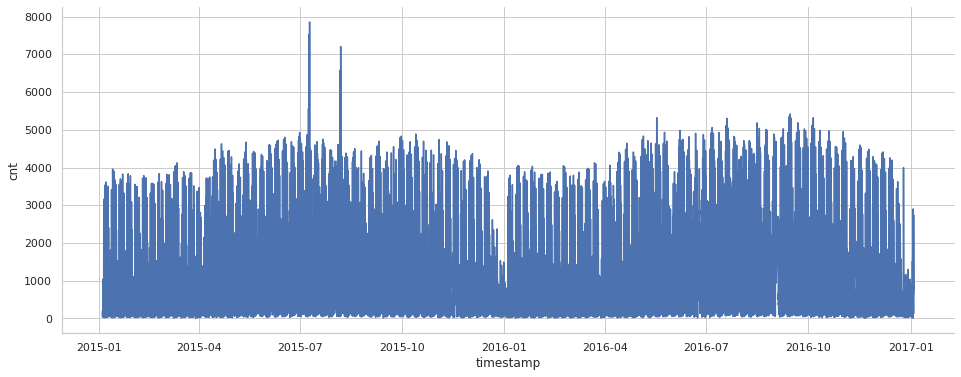

In [18]:
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})
sns.lineplot(data=data, x='timestamp', y='cnt')
sns.despine()

Агрегируем число поездок по дням и визуализируем результат. 

In [19]:
data.sort_values('timestamp', inplace=True)
data.set_index('timestamp', drop=False, inplace=True)
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [20]:
data_cnt = data.resample(rule='D').cnt.sum()
data_cnt.shape

(731,)

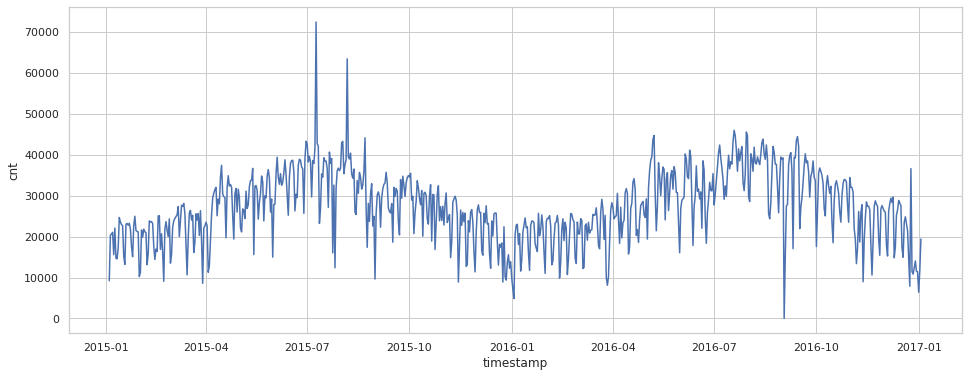

In [21]:
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})
sns.lineplot(data=data_cnt);

Мы обнаружили на графике некоторые скачки.  
Проверим, что же могло произойти в те дни - и насколько эти изменения для нас неожиданны 🤔.  
Построим доверительный интервал вокруг данных, всё что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.  
Чтобы учесть сезонные колебания мы построим доверительный интервал, используя скользящее среднее.  
Для этого разделим дальнейшие действия на несколько этапов:  
сначала посчитаем скользящее среднее, чтобы сгладить ряд  
далее – разницу между наблюдаемыми и сглаженными значениями  
определим верхние и нижние границы 99% доверительного интервала  
найдем причины аномалий!  

In [22]:
data_cnt.head()

timestamp
2015-01-04     9234
2015-01-05    20372
2015-01-06    20613
2015-01-07    21064
2015-01-08    15601
Freq: D, Name: cnt, dtype: int64

In [23]:
data_roll = data_cnt.rolling(window=3).mean().reset_index() #
data_roll.head()

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667


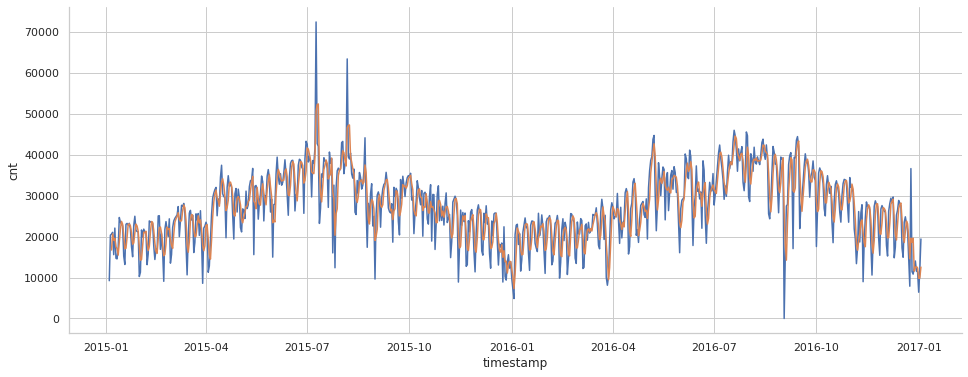

In [24]:
sns.lineplot(data=data_cnt.to_frame().reset_index(), x='timestamp', y='cnt')
sns.lineplot(data=data_roll, x='timestamp', y='cnt')
sns.despine()

Посчитаем разницу между наблюдаемыми и подсчитанными значениями.  

In [25]:
data_diff = data_roll.merge(data_cnt.reset_index(), on='timestamp')
data_diff = data_diff.rename(columns={'cnt_x': 'rolling', 'cnt_y': 'cnt'})
data_diff.head()

,timestamp,rolling,cnt
0,2015-01-04,NaN,9234
1,2015-01-05,NaN,20372
2,2015-01-06,16739.666667,20613
3,2015-01-07,20683.000000,21064
4,2015-01-08,19092.666667,15601


In [26]:
data_diff['diff'] = data_diff['cnt'] - data_diff['rolling']
data_diff['std'] = np.std(data_diff['diff'])
data_diff.head()

,timestamp,rolling,cnt,diff,std
0,2015-01-04,NaN,9234,NaN,4558.586641
1,2015-01-05,NaN,20372,NaN,4558.586641
2,2015-01-06,16739.666667,20613,3873.333333,4558.586641
3,2015-01-07,20683.000000,21064,381.000000,4558.586641
4,2015-01-08,19092.666667,15601,-3491.666667,4558.586641


Определим границы интервалов. 

In [27]:
sigma_99_percent = 2.576
data_diff['upper_bound'] = data_diff['rolling'] + data_diff['std'] * sigma_99_percent
data_diff['lower_bound'] = data_diff['rolling'] - data_diff['std'] * sigma_99_percent
data_diff.head()

,timestamp,rolling,cnt,diff,std,upper_bound,lower_bound
0,2015-01-04,NaN,9234,NaN,4558.586641,NaN,NaN
1,2015-01-05,NaN,20372,NaN,4558.586641,NaN,NaN
2,2015-01-06,16739.666667,20613,3873.333333,4558.586641,28482.585854,4996.747479
3,2015-01-07,20683.000000,21064,381.000000,4558.586641,32425.919188,8940.080812
4,2015-01-08,19092.666667,15601,-3491.666667,4558.586641,30835.585854,7349.747479


Изучим аномально высокие значения!  

In [28]:
anomaly = data_diff[(data_diff.cnt > data_diff.upper_bound) | (data_diff.cnt < data_diff.lower_bound)]
anomaly.head()

,timestamp,rolling,cnt,diff,std,upper_bound,lower_bound
130,2015-05-14,28709.333333,15609,-13100.333333,4558.586641,40452.252521,16966.414146
186,2015-07-09,50705.000000,72504,21799.000000,4558.586641,62447.919188,38962.080812
189,2015-07-12,36036.666667,23240,-12796.666667,4558.586641,47779.585854,24293.747479
201,2015-07-24,31013.666667,16034,-14979.666667,4558.586641,42756.585854,19270.747479
214,2015-08-06,46627.333333,63468,16840.666667,4558.586641,58370.252521,34884.414146


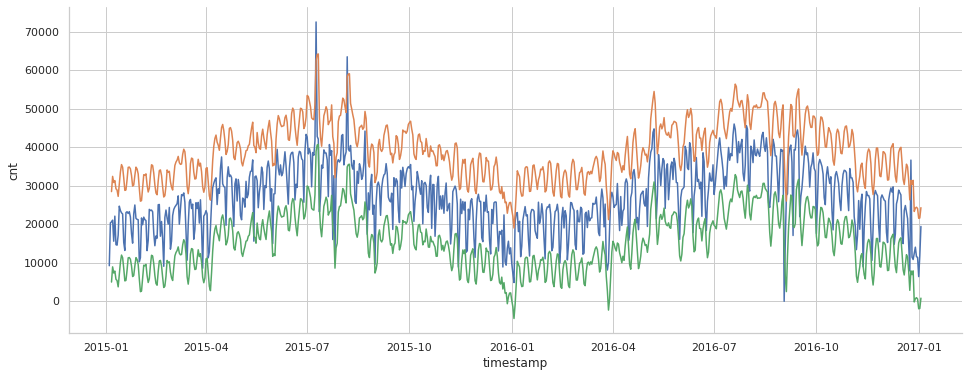

In [29]:
sns.lineplot(data=data_diff, x='timestamp', y='cnt')
sns.lineplot(data=data_diff, x='timestamp', y='upper_bound')
sns.lineplot(data=data_diff, x='timestamp', y='lower_bound')
sns.despine()

Судя по новостям от 2015-07-09 причина аномалий - забастовки в метро.  
Причина падения числа аренд 2016-09-02 - шибка при сборе данных.